In [13]:
import numpy as np
import skfuzzy as fuzz
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skfuzzy import control as ctrl
import warnings
warnings.filterwarnings("ignore")

In [14]:
df = pd.read_excel('dataset.xlsx', nrows=279)
df["SESSO"].replace({'M': 0., 'F': 1.}, inplace=True)
df["TARGET"].replace({2.0: 1.}, inplace=True)
df = df.drop(columns=["AGE", "SESSO"])
for key in df.keys():
    df[key] = pd.to_numeric(df[key].astype(str).str.replace(",", ""), errors='coerce')
correlations = np.array(df.corrwith(df['TARGET'], method="kendall"))[:-1]
print(f"Correlations with TARGET:\n", df.corrwith(df['TARGET'], method="kendall"))
beta = 0.2
chosen_corrs = correlations > beta
features = df.columns.values
features = features[:-1]
X = df.drop(columns='TARGET').to_numpy(dtype=np.float64)
# X = df[['Eosinofili', 'AST', 'LDH', 'PCR', 'Monociti', 'Linfociti']].to_numpy(dtype=np.float64)
X = X[:, chosen_corrs]
y = df['TARGET'].to_numpy(dtype=np.float64)

Correlations with TARGET:
 WBC          -0.178520
Piastrine    -0.092355
Neutrofili   -0.100715
Linfociti    -0.213555
Monociti     -0.185434
Eosinofili   -0.215767
Basofili     -0.171577
PCR           0.238826
AST           0.410829
ALT           0.224363
ALP          -0.074779
GGT           0.165086
LDH           0.363080
TARGET        1.000000
dtype: float64


In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=300, random_state=0)
imp.fit(df)
df = np.round(imp.transform(df), 1)

In [16]:
df_train, df_test = train_test_split(df, stratify=y, random_state=104, test_size=0.2)
df_train = np.array(df_train)
df_test = np.array(df_test)

In [17]:
from pyit2fls import T1FS, T1Mamdani, T1FS_plot, singleton_mf, trapezoid_mf, rtri_mf, ltri_mf, tri_mf, crisp, gaussian_mf
import matplotlib.pyplot as plt
import math
from functools import reduce

class Control:
    def __init__(self, domain, name):
        self.name = name
        self.domain = domain
        self.terms = []

    def add_t1fs(self, name, mf, params):
        t1fs = T1FS(self.domain, mf, params)
        setattr(self, name, [mf, params, t1fs])
        self.terms.append((name, mf, params, t1fs))

    def view(self):
        title = f"{self.name}"
        T1FS_plot(*[term[3] for term in self.terms], legends=[term[0] for term in self.terms], title=title)
        
    def get_term(self, x):
        y_s = {}
        for term in self.terms:
            y_s[term[0]] = term[1](x, term[2])

        return max(y_s, key=y_s.get)

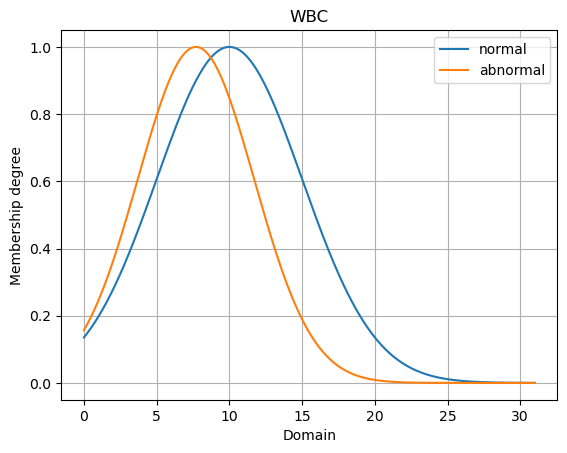

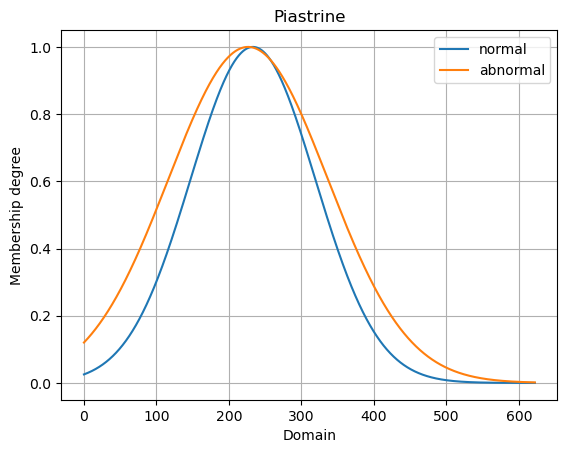

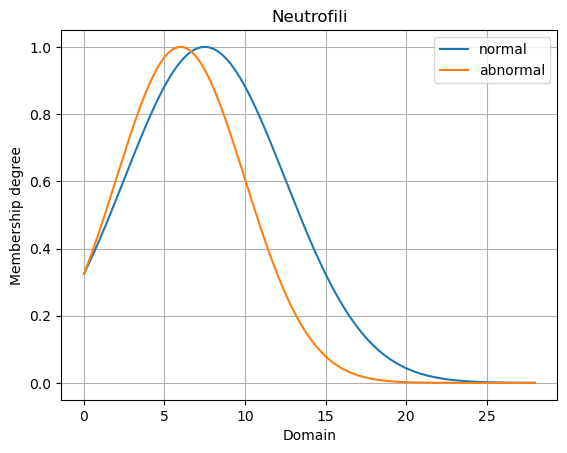

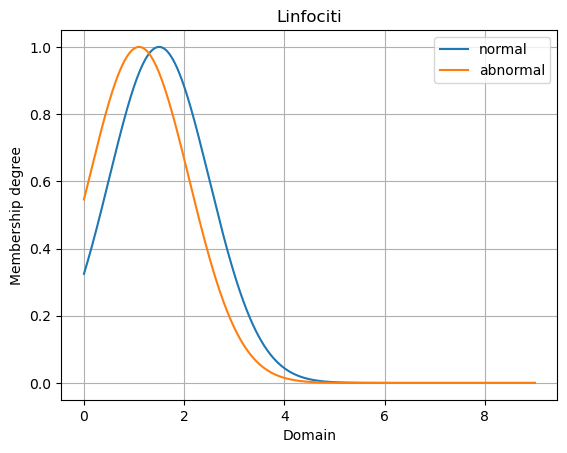

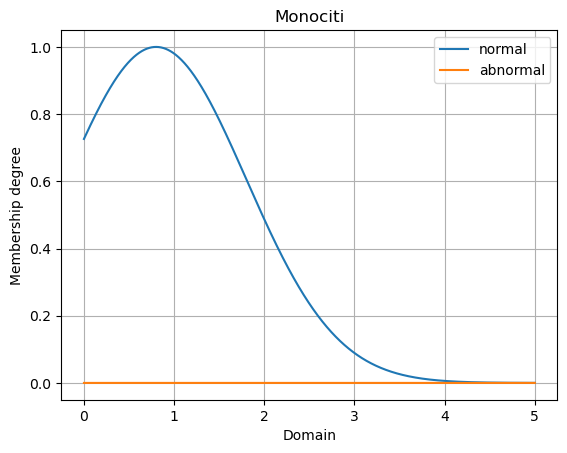

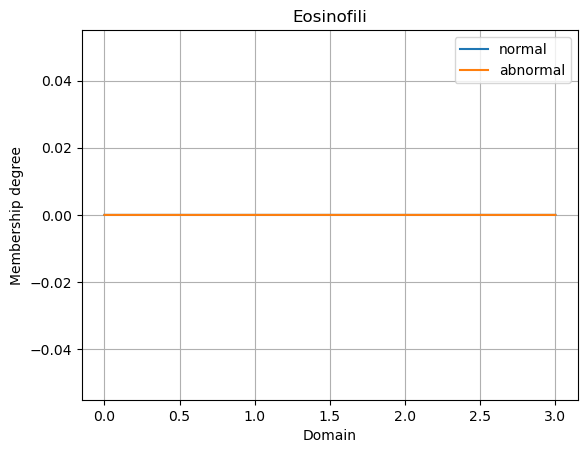

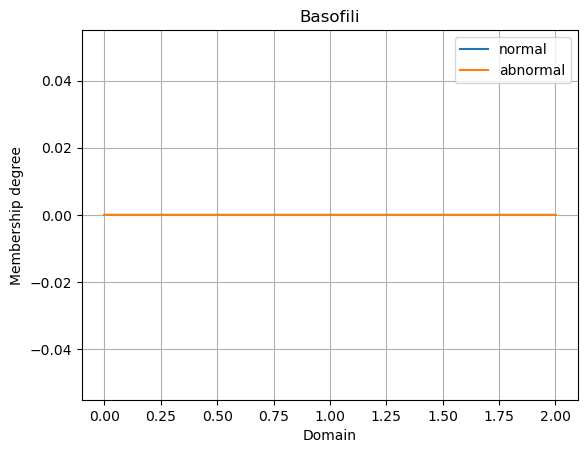

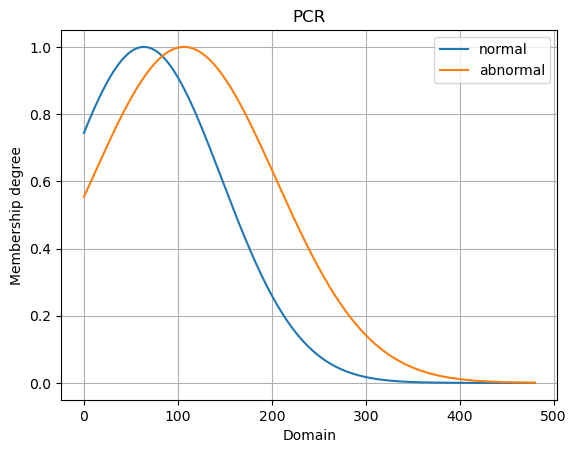

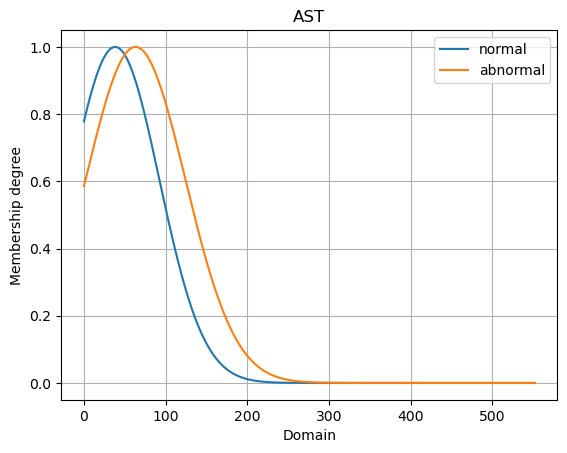

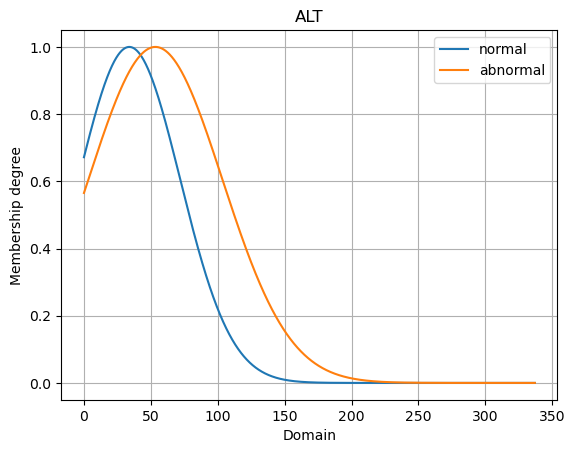

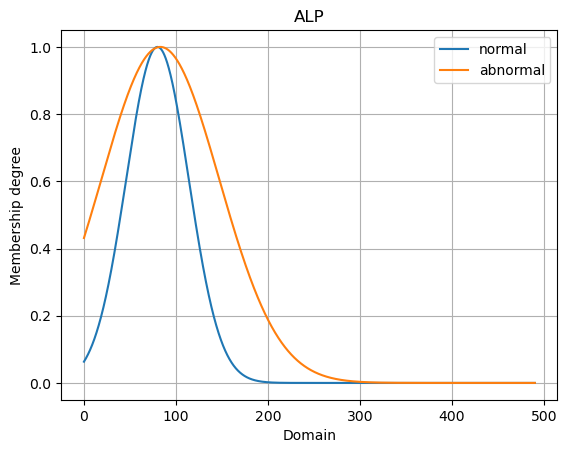

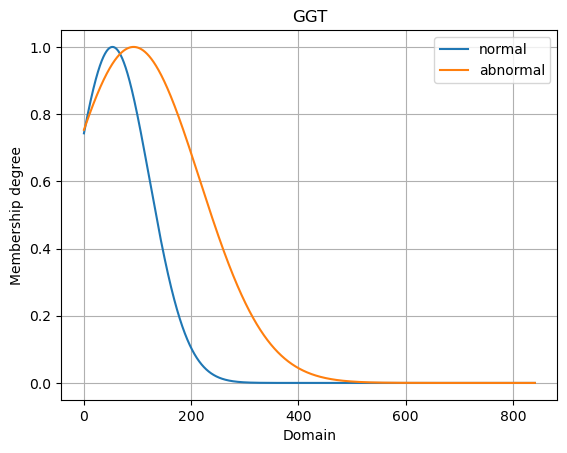

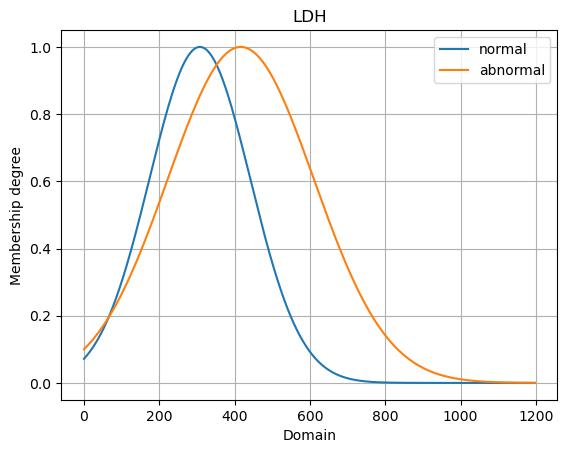

In [18]:
controls = []
for i, feature in enumerate(features):
    control = Control(np.linspace(0, np.round(max(df_train[:, i]) + 2), 10000), feature)
    temp_df = df_train[df_train[:, -1] == 0]
    max_value = max(temp_df[:, i])
    sd = np.round(np.std(temp_df[:, i]))
    avg_value = np.round(np.mean(temp_df[:, i]), 1)
    min_value = min(temp_df[:, i])
    control.add_t1fs('normal', gaussian_mf, [avg_value, sd, 1])
    # control.add_t1fs('normal', tri_mf, [min_value, avg_value, max_value, 1])
    
    temp_df = df_train[df_train[:, -1] == 1]
    max_value = max(temp_df[:, i])
    sd = np.round(np.std(temp_df[:, i]))
    avg_value = np.round(np.mean(temp_df[:, i]), 1)
    min_value = min(temp_df[:, i])
    control.add_t1fs('abnormal', gaussian_mf, [avg_value, sd, 1])
    # control.add_t1fs('abnormal', tri_mf, [min_value, avg_value, max_value, 1])

    control.view()
    controls.append(control)

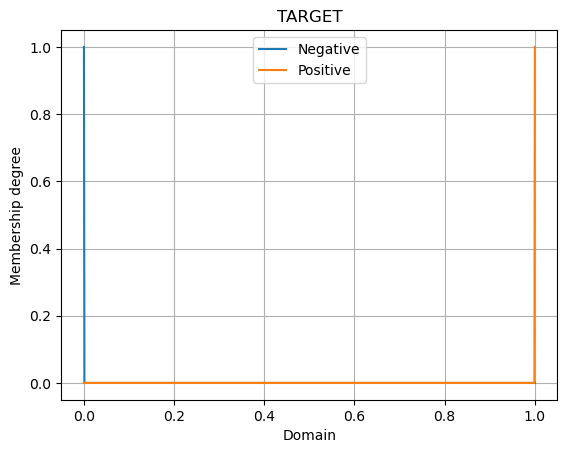

In [19]:
TARGET = Control(np.linspace(0., 1., 1001), 'TARGET')
# TARGET.add_t1fs('Negative', rtri_mf, [1, 0, 1])
# TARGET.add_t1fs('Positive', ltri_mf, [0, 1, 1])
TARGET.add_t1fs('Negative', singleton_mf, [0, 1])
TARGET.add_t1fs('Positive', singleton_mf, [1, 1])
# TARGET.add_t1fs('IDK', singleton_mf, [2, 1])
TARGET.view()

In [20]:
# antecedents = [WBC, Piastrine, Neutrofili, Linfociti, Monociti, Eosinofili, Basofili, PCR, AST, ALT, ALP, GGT, LDH]
# antecedents = [Linfociti, Eosinofili, Basofili, ALT, LDH]
consequents = [TARGET]

In [21]:
SYS = T1Mamdani(engine="Minimum", defuzzification="CoG")
for feature in features:
    SYS.add_input_variable(feature)
SYS.add_output_variable("TARGET")

In [22]:
rules = []
for row in df_train:
    ants = []
    rule_str = ""
    for i, feature in enumerate(features):
        if(not math.isnan(row[i])):
            rule_str += f"{feature} is {controls[i].get_term(row[i])} AND "
            ants.append((feature, getattr(controls[i], controls[i].get_term(row[i]))[2]))
    rule_str = rule_str[:-4]
    rule_str += "THEN "
    cons = []
    for i, consequent in enumerate(consequents):
        cons.append((consequent.name, getattr(consequent, consequent.get_term(row[-(i+1)]))[2]))
        rule_str += f"{consequent.name} is {consequent.get_term(row[-(i+1)])} AND "
    rule_str = rule_str[:-4]
    if(not (rule_str in rules)):
        rules.append(rule_str)
        SYS.add_rule(ants, cons)

print(f"Total of {len(rules)} rules extracted: ")
print(*rules, sep="\n")

Total of 110 rules extracted: 
WBC is abnormal AND Piastrine is abnormal AND Neutrofili is abnormal AND Linfociti is abnormal AND Monociti is normal AND Eosinofili is normal AND Basofili is normal AND PCR is normal AND AST is abnormal AND ALT is normal AND ALP is abnormal AND GGT is abnormal AND LDH is abnormal THEN TARGET is Positive 
WBC is normal AND Piastrine is abnormal AND Neutrofili is normal AND Linfociti is normal AND Monociti is normal AND Eosinofili is normal AND Basofili is normal AND PCR is normal AND AST is normal AND ALT is normal AND ALP is abnormal AND GGT is normal AND LDH is normal THEN TARGET is Negative 
WBC is abnormal AND Piastrine is abnormal AND Neutrofili is abnormal AND Linfociti is normal AND Monociti is normal AND Eosinofili is normal AND Basofili is normal AND PCR is normal AND AST is normal AND ALT is normal AND ALP is abnormal AND GGT is normal AND LDH is normal THEN TARGET is Negative 
WBC is abnormal AND Piastrine is abnormal AND Neutrofili is abnormal

In [23]:
def predict(x):
    inp = {}
    for i, term in enumerate(x[:(len(x)-1)]):
        if(not math.isnan(term)):
            inp[features[i]] = term
    
    s, c = SYS.evaluate(inp)
    trueval = test[len(x)-1]
    pred = c["TARGET"]
    pred_term = TARGET.get_term(pred)
    if(not math.isnan(pred)):
        pred = np.round(pred)
        pred_term = TARGET.get_term(pred)
        pred = 1 if (pred_term == "Positive") else 0
        print(f"actual: {trueval}, pred: {pred}")
    else:
        print(f"actual: {trueval}, pred: nan (Could not match record with a rule)")
    return (pred == x[len(x)-1])

count = 0

for i, test in enumerate(df_test):
    print(f"Test no.{i}")
    if(predict(test)): count += 1
    print()

Test no.0
actual: 0.0, pred: nan (Could not match record with a rule)

Test no.1
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.2
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.3
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.4
actual: 0.0, pred: nan (Could not match record with a rule)

Test no.5
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.6
actual: 0.0, pred: nan (Could not match record with a rule)

Test no.7
actual: 0.0, pred: nan (Could not match record with a rule)

Test no.8
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.9
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.10
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.11
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.12
actual: 1.0, pred: nan (Could not match record with a rule)

Test no.13
actual: 0.0, pred: nan (Could not match record with a rule)

Te

In [24]:
def get_accuracy(pred_count, acutual_count):
    return (pred_count*100)/acutual_count

print("Accuracy: ", np.round(get_accuracy(count, len(df_test))), "%")

Accuracy:  0.0 %
